In [2]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from astropy import *
from astropy.table import Table


%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


In [3]:
M = 1.16
P = 628.
year = 365.25
aearth = 1.
rsun = 6.957e8
au = 149597870700 # m

print rsun/au

0.00465046726096


In [4]:
const = aearth**3 / year**2

In [5]:
a = (P**2 * const)**(1/3.)
print a

1.43520171971


In [6]:
R = M**0.8
print R

1.12607260049


In [7]:
def L(M):
    logl = 4.328*np.log(M) -0.002
    return np.exp(logl)
    
print L(M)

1.8971671163651533


In [8]:
def teffpred(L,R):
    return 5777.*(L/R**2.)**0.25

print teffpred(L(M),R)

6389.186553023514


In [9]:
def teq(Teff,Rstar,axis,f,A):
    '''Teff is star, R is stellar radius, a is semimajor axis, A is Bond albedo, f is the 
    geometric factor of reradiation'''
    
    return Teff*np.sqrt(Rstar*rsun/2./(axis*au))*(f*(1.-A))**0.25

In [10]:
tstar = teffpred(L(M),R)

In [11]:
tplan = teq(tstar,R,a,2.0,0.5)
print tplan

272.9012905319823


In [12]:
L(M)/(a**2)

0.9210425546480684

In [13]:
R

1.1260726004890476

In [14]:
## earth

Tearth = teq(5777,1.,1.,2.0,0.29)
print Tearth

304.09393010897196


In [15]:
tvenus = teq(5770,1.,0.72,1.0,0.6)
print tvenus

260.77014026225146


In [16]:
mas2rad = 1000*3600*180./np.pi

In [17]:
## today

giant_teff = 3934.

distance = 19.34 # pc
angular = 20.58e-3
print angular

linear = angular*distance*(au)/rsun



0.02058


In [18]:
tgiant = teq(giant_teff,linear,a,2.0,0.5)

In [19]:
tgiant

1464.9196508550642

## Now let's use MCMC to get uncertainties on these. We have uncertainties in mass and everthing else is derived from scaling relations.

In [20]:
nmass = 10000
masses = 1.16 + np.random.randn(nmass)*0.07

In [21]:
ells = L(masses)
arrs = masses**0.8

teffs = teffpred(ells,arrs)

In [22]:
const = aearth**3 / year**2

In [23]:
axes = (P**2 * const*masses)**(1/3.)

In [24]:
teqs = teq(teffs,arrs,axes,2.,0.29)


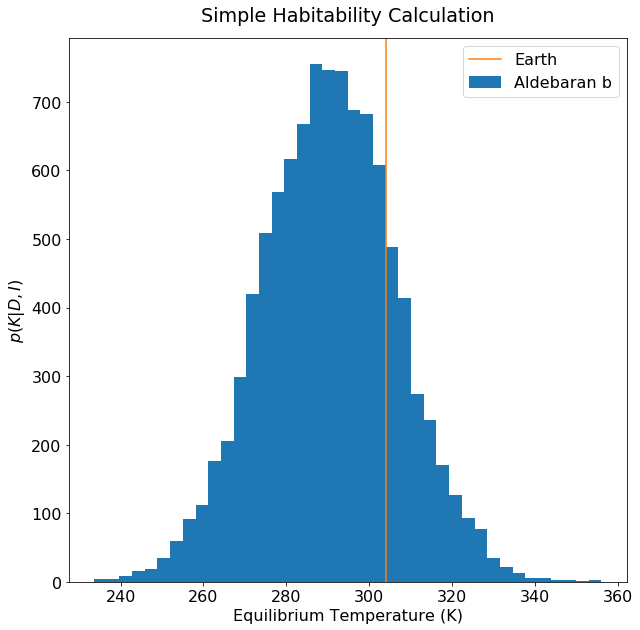

In [25]:
h = plt.hist(teqs,bins=40,label="Aldebaran b")
plt.axvline(Tearth,color=colours[1],label="Earth")
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel(r"$p(K|D,I)$")
plt.legend()
plt.title('Simple Habitability Calculation',y=1.02)
plt.savefig('aldebaran_b_habitability.png')

In [26]:
print np.mean(teqs), np.std(teqs)

290.41647494286747 16.15008851547539


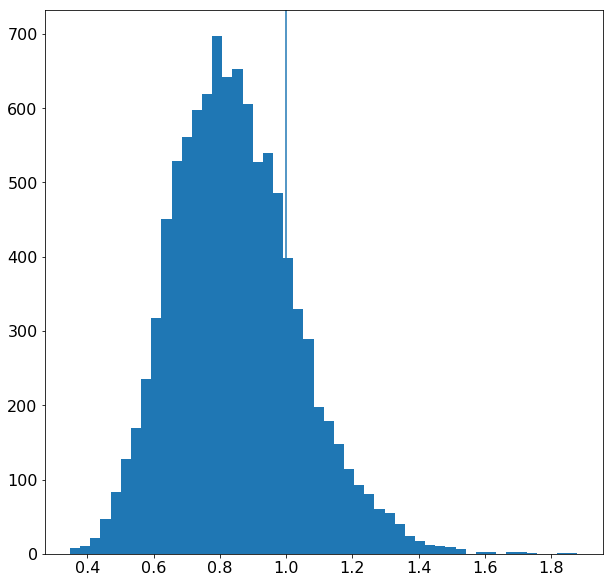

In [27]:
h = plt.hist(ells/axes**2.,bins=50)
plt.axvline(1.0)

In [28]:
print np.mean(ells/(axes**2.)), np.std(ells/(axes**2.))

0.8473281275046407 0.18814452625446132


In [29]:
print np.mean(ells), np.std(ells)

1.9424393906260204 0.5107409100211457


In [30]:
print np.mean(axes), np.std(axes)

1.5070538345203346 0.03058938072392535


## Let's do this with proper stellar models

In [38]:
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

TypeError: super() takes at least 1 argument (0 given)

In [33]:
%%time
rad = mist.radius(M,6.,-0.3)

NameError: name 'mist' is not defined

In [32]:
rad

2.4409202906989584

In [33]:
t = np.linspace(9.8,11.,1000)
t = np.log10(np.linspace(1e6,15e9,1000))
numaxes = mist.nu_max(1.,t,0.0)
radii = mist.radius(1.,t,0.0)

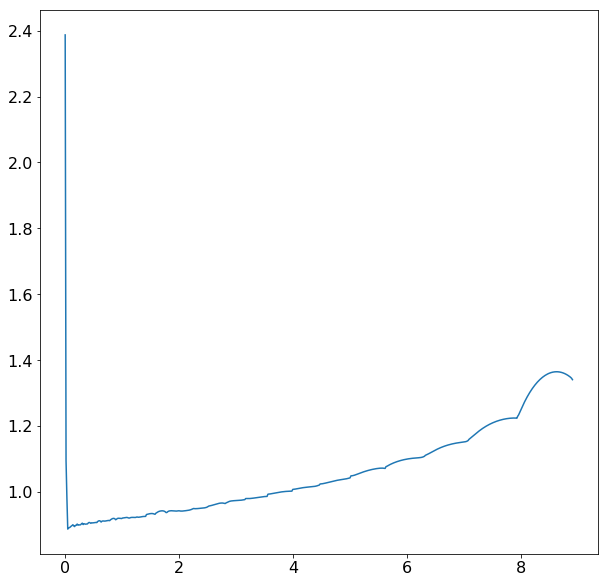

In [34]:
# plt.plot(t,numaxes)
plt.plot(10**t/1e9,radii)

In [38]:
i

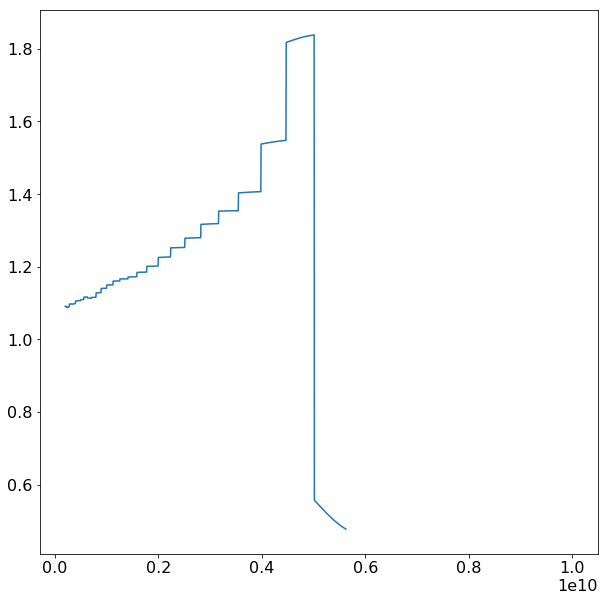

In [39]:
plt.plot(10**t,rr)

In [189]:
### ok now do aldebaran
fehs = -0.15 + 0.2*np.random.randn(nmass)
radii = mist.radius(masses,np.log10(2.e9),fehs)
logLs = mist.logL(masses,np.log10(2.e9),fehs)

In [41]:
ells2 = 10**logLs

In [42]:
ells2.shape

(10000,)

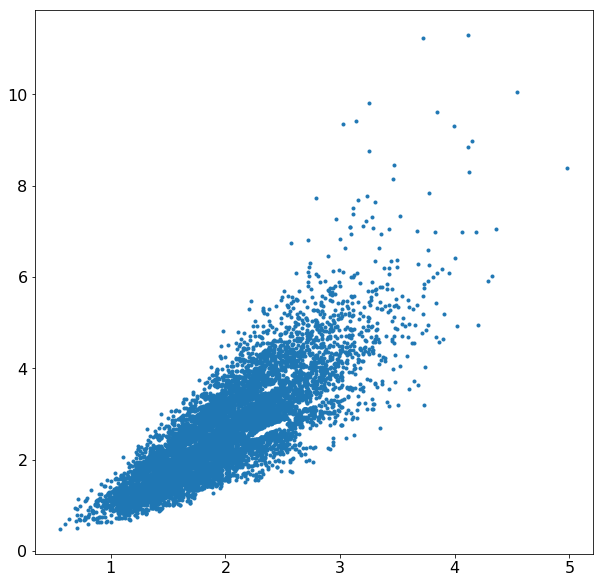

In [43]:
plt.plot(ells,ells2,'.')

In [196]:
# times = np.linspace(0.5,10,50.)
times = np.linspace(7.5,10,100)

means, stds = [], []
meanells, stdells = [], []
uppers, lowers = [], []

fehs = -0.15 + 0.2*np.random.randn(nmass)

for t in times:
    radii = mist.radius(masses,t,fehs)
    logLs = mist.logL(masses,t,fehs)
    ells2 = 10**logLs
    meanells.append(np.nanmean(ells2))
    stdells.append(np.nanstd(ells2))
    
    ratios = ells2/axes**2.
    ratios = ratios[np.isfinite(ratios)]
    upper = np.percentile(ratios,50+34.1)
    lower = np.percentile(ratios,50-34.1)
    
    means.append(np.nanmean(ratios))
    stds.append(np.nanstd(ratios))
    uppers.append(upper)
    lowers.append(lower)
    
means = np.array(means)
stds = np.array(stds)
uppers = np.array(uppers)
lowers = np.array(lowers)

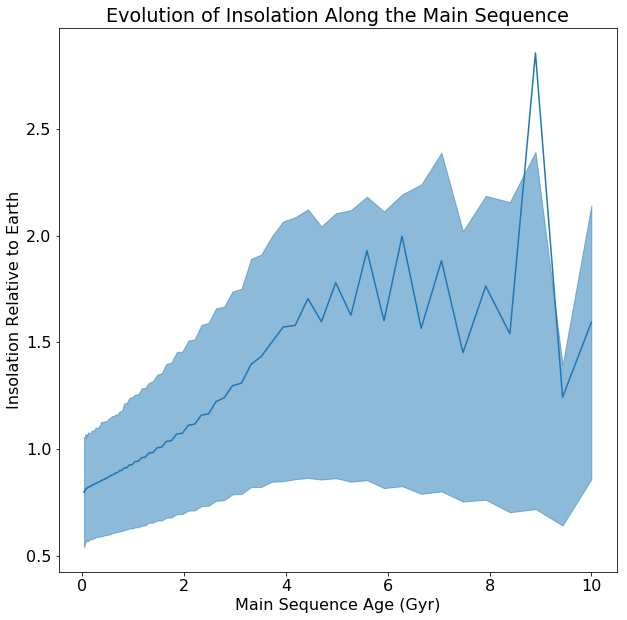

In [197]:
# plt.plot(times,means,'x')
# plt.errorbar(times,means,yerr=stds,linestyle='none')
times = (10**times)/1.e9
plt.plot(times,means,'-')
plt.fill_between(times,lowers,uppers,color=colours[0],alpha=0.5)
plt.xlabel('Main Sequence Age (Gyr)')
plt.ylabel('Insolation Relative to Earth')
plt.title('Evolution of Insolation Along the Main Sequence')
plt.savefig('insolation.png')

In [191]:
times = np.linspace(7.5,11.0,1000)
Teff = 10**mist.logTeff(masses.mean(),times,fehs.mean())
logLs = mist.logL(masses.mean(),times,fehs.mean())

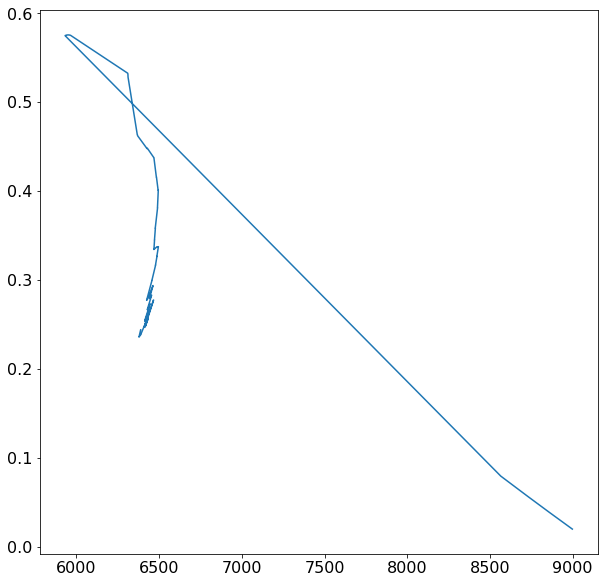

In [195]:
plt.plot(Teff,logLs)

ValueError: x and y must have same first dimension, but have shapes (1000,) and (100,)

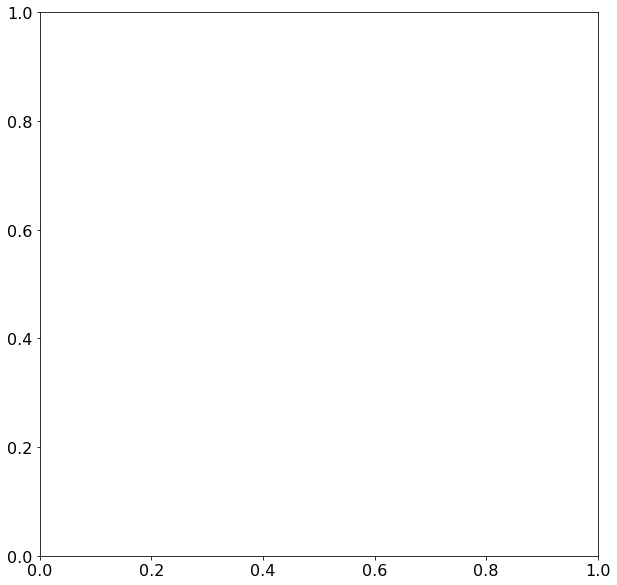

In [178]:
plt.plot(times,meanells,'x')
plt.errorbar(times,meanells,yerr=stdells,linestyle='none')

In [179]:
print meanells[0], stdells[0]
print meanells[-1], stdells[-1]

1.83738244938 0.62307775898
3.03870208643 1.9231845204


In [180]:
print means[0], stds[0]
print means[-1], stds[-1]

0.800578307893 0.242984244482
1.31957004443 0.779615099737


In [181]:
print axes.mean()
print axes.std()

1.50754751366
0.0307075626449


In [182]:
ratios.max()

32.989120926269663

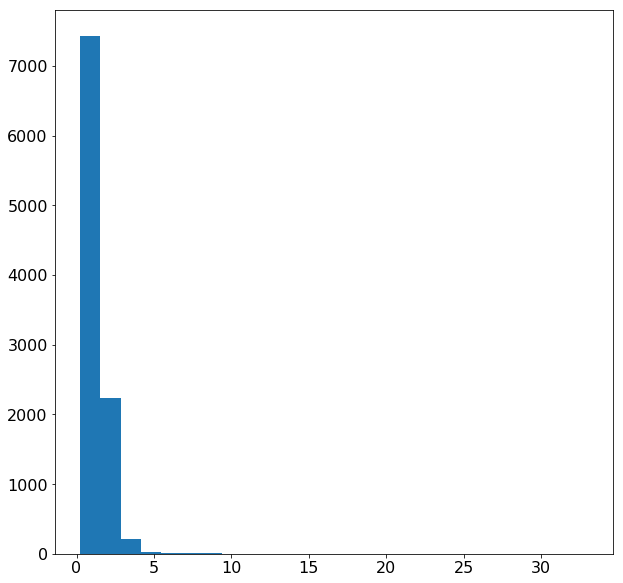

In [183]:
k = plt.hist(ratios,bins=25)
# plt.axvline(1.0,color=colours[1])

In [184]:
print np.mean(ells2/(axes**2.)), np.std(ells2/(axes**2.))

nan nan


In [185]:
# arrs2 = mist.radius(masses,np.log10(2e9),-0.34)
arrs2 = mist.radius(masses,np.log10(1e9),-0.15)

In [186]:
teffs2 = teffpred(ells2,arrs2)

In [187]:
teqs = teq(teffs2,arrs2,axes,2.,0.29)


ValueError: max must be larger than min in range parameter.

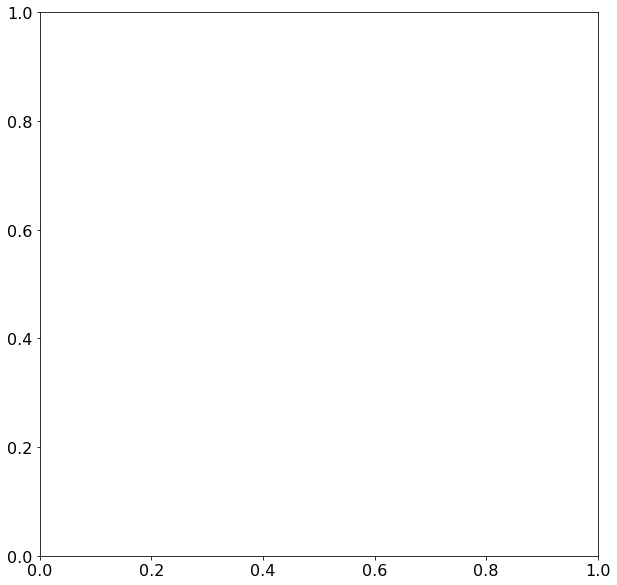

In [188]:
h = plt.hist(teqs,bins=25,label="Aldebaran b")
plt.axvline(Tearth,color=colours[1],label="Earth")
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel(r"$p(K|D,I)$")
plt.legend()
plt.title('MIST Habitability Calculation',y=1.02)
plt.savefig('aldebaran_b_habitability.png')

In [171]:
print np.mean(teqs), np.std(teqs)

nan nan


In [157]:
Tearth

304.09393010897196

## Some tests

In [198]:
mist = MIST_Isochrone()

In [199]:
mist.radius(1.0, 9.7, 0.0)

1.0425456393809822

In [212]:
ages = np.log10(np.linspace(1,12,100)*1.e9)

In [213]:
radii = mist.radius(1.0,ages,0.0)
logLs = mist.logL(1.0,ages,0.0)
Teffs = mist.Teff(1.0,ages,0.0)

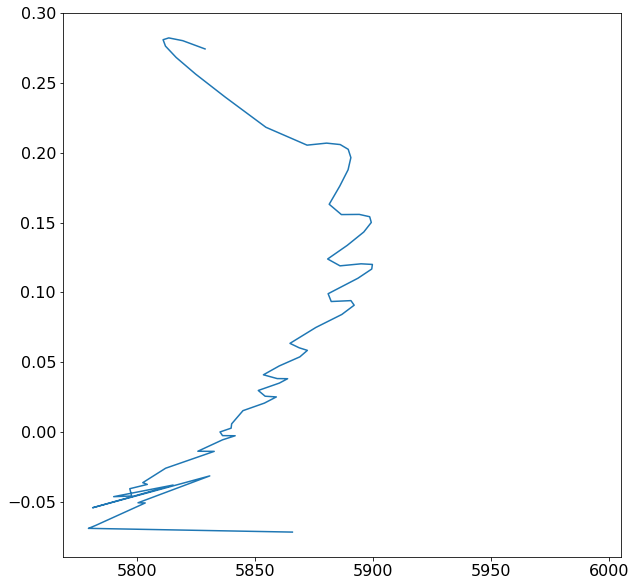

In [214]:
plt.plot(Teffs,logLs)

In [218]:
help(mist.evtrack)

Help on method evtrack in module isochrones.isochrone:

evtrack(self, m, feh=0.0, minage=None, maxage=None, dage=0.02, return_df=True) method of isochrones.mist.isochrone.MIST_Isochrone instance
    Returns evolution track for a single initial mass and feh.
    
    :param m: 
        Initial mass of desired evolution track.
    
    :param feh: (optional) 
        Metallicity of desired track.  Default = 0.0 (solar)
    
    :param minage, maxage: (optional)
        Minimum and maximum log(age) of desired track. Will default
        to min and max age of model isochrones. 
    
    :param dage: (optional)
        Spacing in log(age) at which to evaluate models.  Default = 0.02
    
    :param return_df: (optional)
        Whether to return a ``DataFrame`` or dicionary.  Default is ``True``.
        
    
    :return:
        Either a :class:`pandas.DataFrame` or dictionary
        representing the evolution
        track---fixed mass, sampled at chosen range of ages.



1.08
1.08842105263
1.09684210526
1.10526315789
1.11368421053
1.12210526316
1.13052631579
1.13894736842
1.14736842105
1.15578947368
1.16421052632
1.17263157895
1.18105263158
1.18947368421
1.19789473684
1.20631578947
1.21473684211
1.22315789474
1.23157894737
1.24


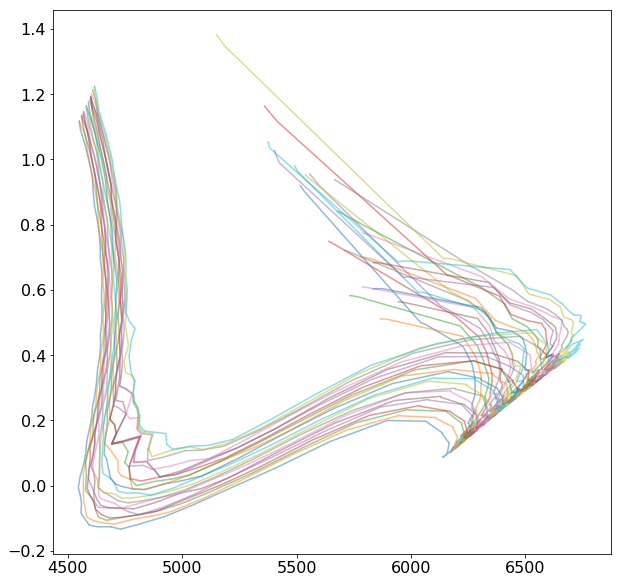

In [249]:
for mass in np.linspace(1.08,1.24,20):
    track = mist.evtrack(mass,feh=-0.16)
    Teffs = track['Teff']
    ages = track['age']
    logLs = track['logL']
    print track['mass'][0]
    plt.plot(Teffs,logLs,alpha=0.5)

In [250]:
Teffs = track['Teff']
ages = track['age']
logLs = track['logL']

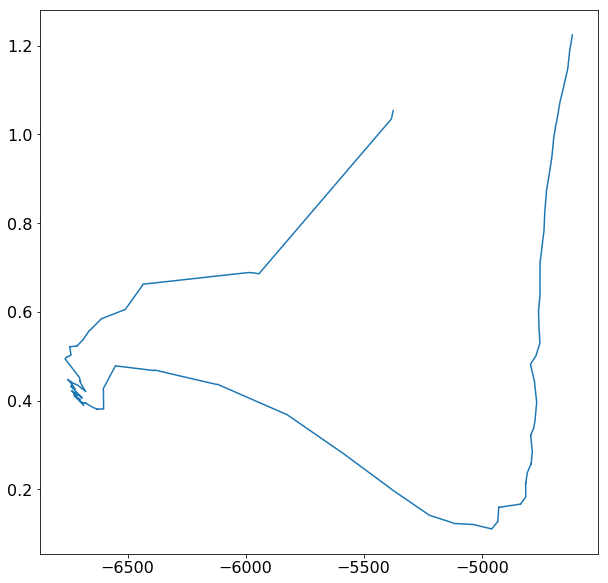

In [251]:
plt.plot(-Teffs,logLs)

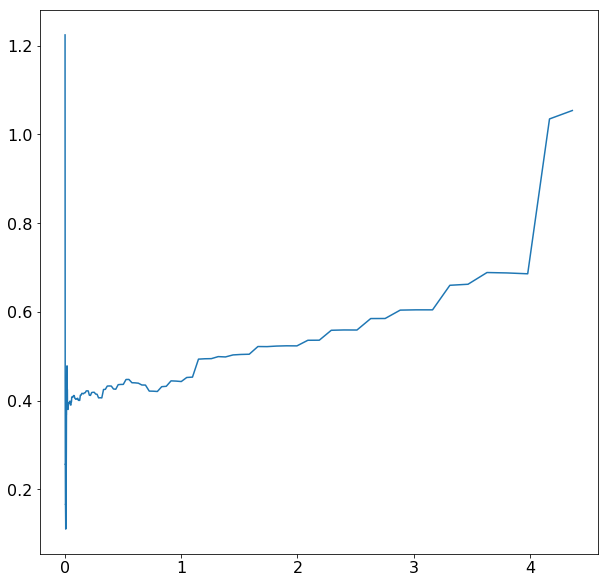

In [254]:
plt.plot(10**ages/1e9,logLs)